## import necessary libraries

In [1]:
import os
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import shutil
import matplotlib.pyplot as plt
import random
from PIL import Image
from collections import Counter
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/My Drive/Uni Research Data/Original Data/OvarianCancer"
print(os.listdir(dataset_path))

['Mucinous', 'Non_Cancerous', 'Clear_Cell', 'Serous', 'Endometri', 'train', 'test']


In [ ]:
class_names = os.listdir(dataset_path)
print("Classes found:", class_names)

Classes found: ['Mucinous', 'Non_Cancerous', 'Clear_Cell', 'Serous', 'Endometri', 'train', 'test']


{'Mucinous': 100, 'Non_Cancerous': 99, 'Clear_Cell': 100, 'Serous': 100, 'Endometri': 98}


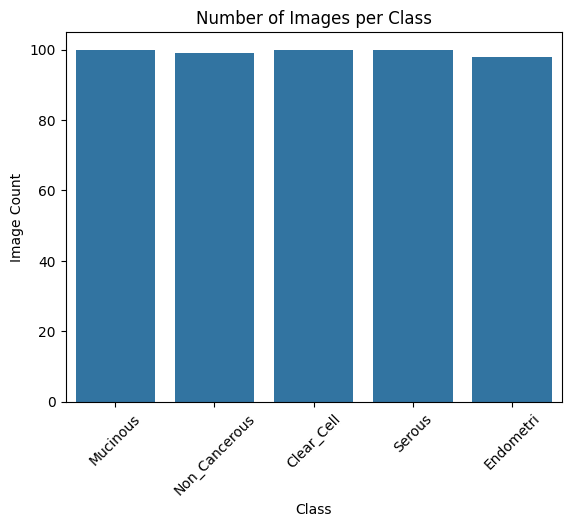

In [ ]:
# Count images for each classes

image_counts = {}

for label in class_names:
    folder = os.path.join(dataset_path, label)
    if os.path.isdir(folder):
        image_counts[label] = len([file for file in os.listdir(folder) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(image_counts)

# Plotting
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title("Number of Images per Class")
plt.xticks(rotation=45)
plt.ylabel("Image Count")
plt.xlabel("Class")
plt.show()


            Width      Height
count   25.000000   25.000000
mean   598.720000  435.360000
std     77.919039   44.587816
min    225.000000  225.000000
25%    613.000000  439.000000
50%    613.000000  441.000000
75%    617.000000  443.000000
max    619.000000  463.000000


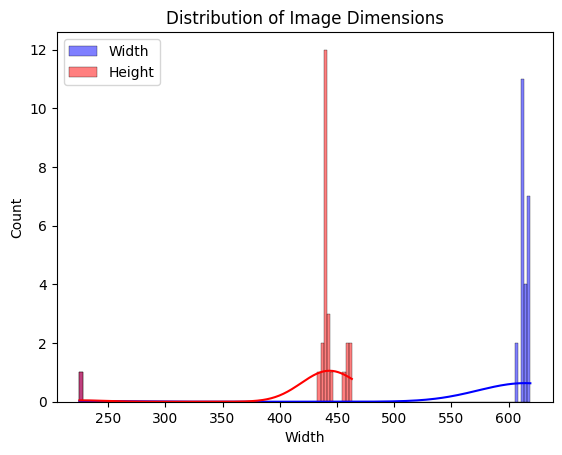

In [ ]:
# Check image sizes

image_shapes = []

for label in class_names:
    folder = os.path.join(dataset_path, label)
    files = os.listdir(folder)
    for file in files[:5]:
        img_path = os.path.join(folder, file)
        try:
            with Image.open(img_path) as img:
                image_shapes.append(img.size)
        except:
            print(f"unreadable image: {img_path}")

# Create DataFrame with images width and height

shape_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print(shape_df.describe())

sns.histplot(shape_df["Width"], kde=True, color="blue", label="Width")
sns.histplot(shape_df["Height"], kde=True, color="red", label="Height")
plt.legend()
plt.title("Distribution of Image Dimensions")
plt.show()


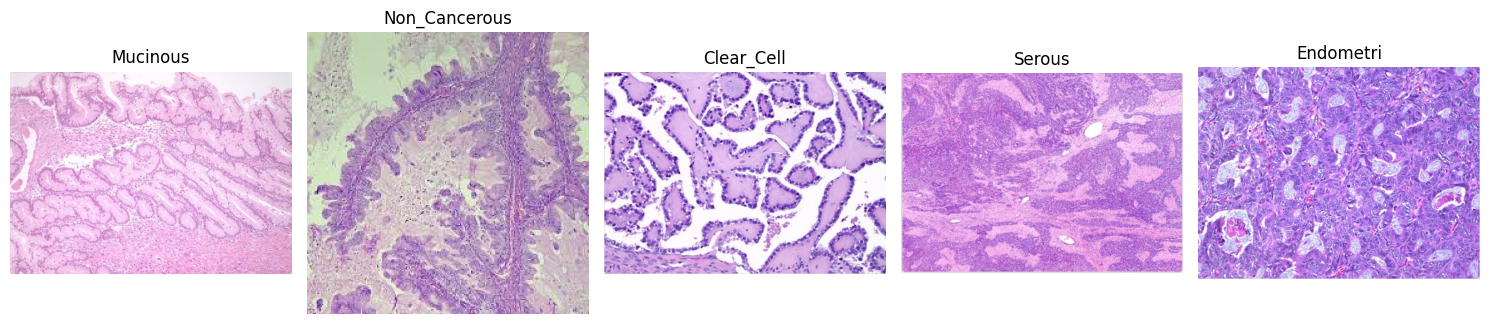

In [ ]:
#Show image samples

fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for i, label in enumerate(class_names):
    folder = os.path.join(dataset_path, label)
    sample_image_path = os.path.join(folder, os.listdir(folder)[0])
    with Image.open(sample_image_path) as img:
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis("off")

plt.tight_layout()
plt.show()


## Process Data

### By manually inspection on data images we could find unusable, noisy images among the data set and then we have to process this data by croping, rotating, Spliting or removing entire image to maintain data usability. We use "ImageJ" software to acheive this target and restore the images in folder called "Pre-Processed Data"

In [5]:
# Define new data set path
new_dataset_path = "/content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed"


In [6]:
class_names = os.listdir(new_dataset_path)
print("Classes found:", class_names)

Classes found: ['Original', 'train', 'test', 'Augmented']


### When processing with 'Image J' the output images' extension changed to '.tif' . so first look at to image extention distribution

Image type distribution: Counter({'.jpg': 296, '.tif': 217, '.png': 24})


<ipython-input-37-2533667991>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ext_df, x="Extension", y="Count", palette="muted")


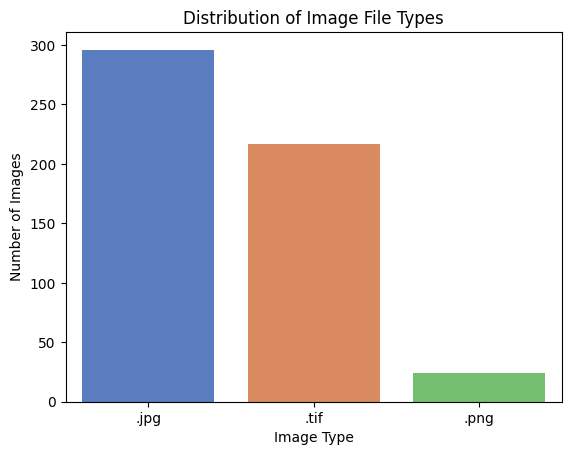

In [ ]:
# show image extensions distribution

image_extensions = []

for label in class_names:
    folder = os.path.join(new_dataset_path, label)
    files = os.listdir(folder)
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp', '.PNG']:  # common formats
            image_extensions.append(ext)

# Count extensions
ext_counter = Counter(image_extensions)
print("Image type distribution:", ext_counter)

# Convert to DataFrame for plotting
ext_df = pd.DataFrame(ext_counter.items(), columns=["Extension", "Count"])

# Plot
sns.barplot(data=ext_df, x="Extension", y="Count", palette="muted")
plt.title("Distribution of Image File Types")
plt.xlabel("Image Type")
plt.ylabel("Number of Images")
plt.show()

{'Endometri': 77, 'Clear_Cell': 92, 'Serous': 184, 'Non_Cancerous': 85, 'Mucinous': 99}


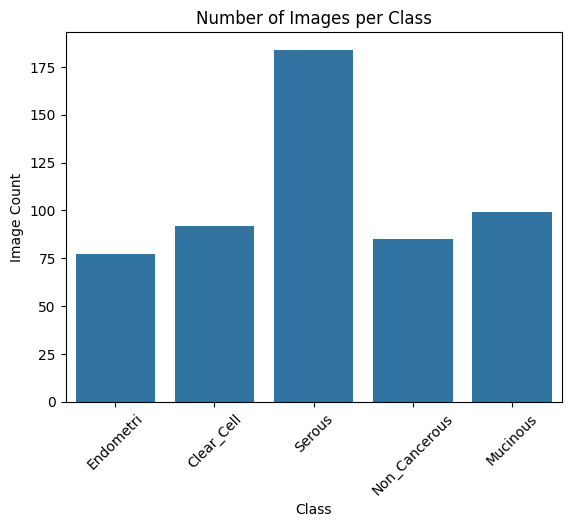

In [ ]:
# Count processed images

image_counts = {}

for label in class_names:
    folder = os.path.join(new_dataset_path, label)
    if os.path.isdir(folder):
        image_counts[label] = len([file for file in os.listdir(folder) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))])

print(image_counts)

# Plotting
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title("Number of Images per Class")
plt.xticks(rotation=45)
plt.ylabel("Image Count")
plt.xlabel("Class")
plt.show()


#### Here the Serious class shows that number of images are increased after the processing. that is because the histopathalogical images in serious are shows large dimwnsion than other images and by spliting them we could increase the number of images.

Note : These spliting is performed while remain the cancerous regon of each split.

In [ ]:
# Move existing processed data into a new folder called "Original"

import os
import shutil

# Existing pre-processed dataset path
old_dataset_path = "/content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed"

# New destination: "Original" folder
original_data_path = os.path.join(old_dataset_path, "Original")
os.makedirs(original_data_path, exist_ok=True)

# Move class folders into "Original"
class_folders = os.listdir(old_dataset_path)

for folder in class_folders:
    folder_path = os.path.join(old_dataset_path, folder)
    if not os.path.isdir(folder_path) or folder == "Original":
        continue

    # Move to Original/
    new_path = os.path.join(original_data_path, folder)
    print(f"Moving {folder_path} → {new_path}")
    shutil.move(folder_path, new_path)

print(" All original data moved into 'Original' folder successfully.")


Moving /content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Endometri → /content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Original/Endometri
Moving /content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Clear_Cell → /content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Original/Clear_Cell
Moving /content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Serous → /content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Original/Serous
Moving /content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Non_Cancerous → /content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Original/Non_Cancerous
Moving /content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Mucinous → /content/drive/My Drive/Uni Resear

In [7]:
# Define new folder paths to perform Augmentation and store augmented images in "Augmented" folder
# Define train and test folders as well

augmented_data_path = "/content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/Augmented"
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
os.makedirs(augmented_data_path, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

### Perform image Augmentation

In [ ]:
# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.02,
    zoom_range=[0.9, 1.2],
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode="reflect"
)

In [ ]:
# Function to augment images and ensure exactly 500 images per category

def augment_images(category):
    category_original_path = os.path.join(original_data_path, category)
    category_augmented_path = os.path.join(augmented_data_path, category)
    os.makedirs(category_augmented_path, exist_ok=True)

    # Copy original images to the augmented folder
    original_images = [img for img in os.listdir(category_original_path) if img.endswith(('.png', '.jpg', '.jpeg', '.JPG', '.tif'))]
    for img in original_images:
        src_path = os.path.join(category_original_path, img)
        dst_path = os.path.join(category_augmented_path, img)
        shutil.copy(src_path, dst_path)

    # Count total images after copying originals
    total_images = len(original_images)

    # Calculate how many more images need to be generated
    num_to_generate = max(500 - total_images, 0)

    if num_to_generate == 0:
        print(f"Skipping {category}, already has 500 images.")
        return

    print(f"Augmenting {num_to_generate} images for category: {category}")

    np.random.shuffle(original_images)  # Shuffle original images

    i = 0
    while i < num_to_generate:
        for img in original_images:
            if i >= num_to_generate:
                break
            img_path = os.path.join(category_original_path, img)
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            save_prefix = os.path.splitext(os.path.basename(img_path))[0]

            for batch in datagen.flow(img_array, batch_size=1,
                                      save_to_dir=category_augmented_path,
                                      save_prefix=save_prefix + '_aug',
                                      save_format="png"):
                i += 1
                break  # Stop after one augmentation per original image

    print(f"Category {category} now has exactly 500 images.")

# Get subcategories
subcategories = [subcat for subcat in os.listdir(original_data_path) if os.path.isdir(os.path.join(original_data_path, subcat))]

# Perform augmentation
for subcat in subcategories:
    augment_images(subcat)

print("Image augmentation completed.")

Augmenting 423 images for category: Endometri
Category Endometri now has exactly 500 images.
Augmenting 408 images for category: Clear_Cell
Category Clear_Cell now has exactly 500 images.
Augmenting 316 images for category: Serous
Category Serous now has exactly 500 images.
Augmenting 415 images for category: Non_Cancerous
Category Non_Cancerous now has exactly 500 images.
Augmenting 401 images for category: Mucinous
Category Mucinous now has exactly 500 images.
Image augmentation completed.


In [ ]:
# Split Data into Train and Test Folders

dataset_path = "/content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed"

# Function to split dataset
def split_and_copy_images(category):
    category_path = os.path.join(augmented_data_path, category)
    images = [img for img in os.listdir(category_path) if img.endswith(('.png', '.jpg', '.jpeg', '.JPG', '.tif'))]

    # Split images into train and test (80-20 split)
    train_files, test_files = train_test_split(images, test_size=0.2, random_state=42)

    for split, file_list in zip(["train", "test"], [train_files, test_files]):
        split_folder = os.path.join(dataset_path, split, category)
        os.makedirs(split_folder, exist_ok=True)

        for file in file_list:
            src_file = os.path.join(category_path, file)
            dst_file = os.path.join(split_folder, file)
            shutil.copy(src_file, dst_file)

# Get subcategories
subcategories = [subcat for subcat in os.listdir(augmented_data_path) if os.path.isdir(os.path.join(augmented_data_path, subcat))]

# Perform dataset splitting
for subcat in subcategories:
    split_and_copy_images(subcat)

print("Dataset splitting completed.")

Dataset splitting completed.


In [ ]:
# Resize all images into 224x224 and change image extensions into ".jpg" common format


dataset_path = "/content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed"
folders = ["train", "test"]
subcategories = ["Clear_Cell", "Endometri", "Mucinous", "Serous", "Non_Cancerous"]
IMG_SIZE = (224, 224)  # Target size

def process_images(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)


        # Check if it's an image file with undesired formats
        if filename.lower().endswith(('.jpg', '.jpeg')):
            continue  # Skip if already in .jpg format

        if filename.lower().endswith(('.png', '.tif', '.tiff', '.JPG')):
            try:
                # Open image
                img = Image.open(file_path)
                rgb_img = img.convert("RGB")  # Convert to RGB (avoids issues with grayscale or transparency)

                # Define new filename with .jpg extension
                new_filename = os.path.splitext(filename)[0] + ".jpg"
                new_file_path = os.path.join(directory, new_filename)

                # Save as .jpg
                rgb_img.save(new_file_path, "JPEG", quality=95)

                # Remove old file
                os.remove(file_path)

                print(f"Converted: {filename} → {new_filename}")

            except Exception as e:
                print(f"Error converting {filename}: {e}")

        # Resize images
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            try:
                img = Image.open(file_path)
                img = img.resize(IMG_SIZE, Image.LANCZOS)  # Resize to 224x224
                img.save(file_path)  # Overwrite original file
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Apply processing to train and test folders
for folder in folders:
    for subcat in subcategories:
        subcat_path = os.path.join(dataset_path, folder, subcat)
        if os.path.exists(subcat_path):
            process_images(subcat_path)

print("All images resized to 224x224 and .JPG files renamed to .jpg.")

All images resized to 224x224 and .JPG files renamed to .jpg.


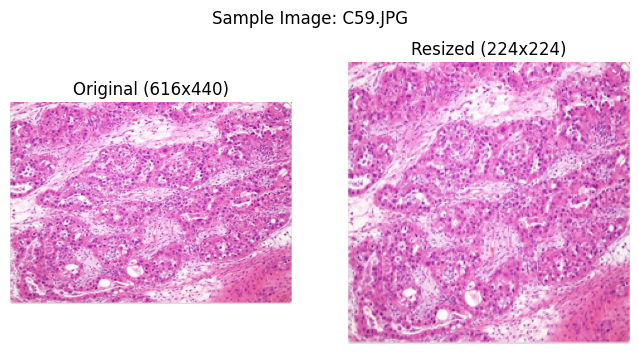

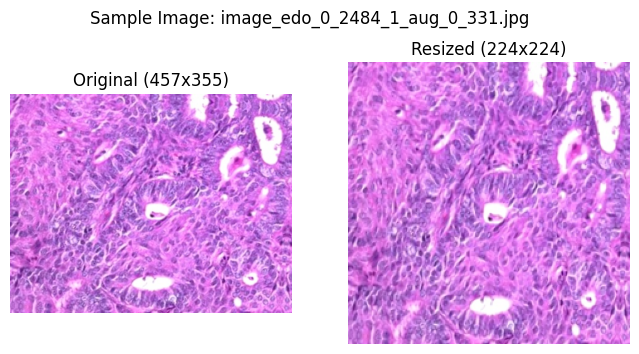

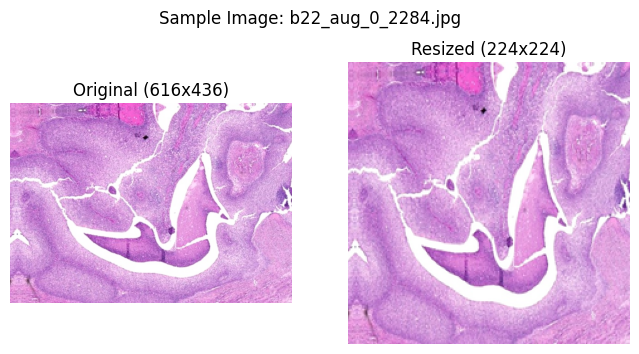

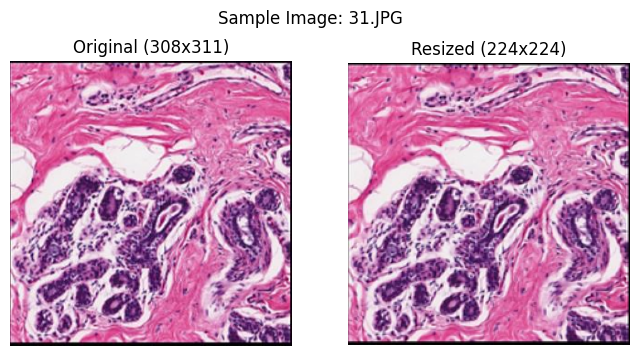

In [ ]:
# Display resized image sample

# Select a random image from the dataset
def get_random_image():
    folder = random.choice(folders)  # Choose train, val, or test
    subcat = random.choice(subcategories)  # Choose a random subtype
    subcat_path = os.path.join(dataset_path, folder, subcat)

    if not os.path.exists(subcat_path) or not os.listdir(subcat_path):
        print(f"No images found in {subcat_path}")
        return None, None

    image_file = random.choice(os.listdir(subcat_path))  # Pick a random image
    return os.path.join(subcat_path, image_file), image_file

# Display original and resized image
def display_images():
    img_path, filename = get_random_image()

    if img_path is None:
        return

    img = Image.open(img_path)

    # Create resized version
    resized_img = img.resize(IMG_SIZE, Image.LANCZOS)

    # Plot both images
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    # Original Image
    ax[0].imshow(img)
    ax[0].set_title(f"Original ({img.size[0]}x{img.size[1]})")
    ax[0].axis("off")

    # Resized Image
    ax[1].imshow(resized_img)
    ax[1].set_title(f"Resized ({IMG_SIZE[0]}x{IMG_SIZE[1]})")
    ax[1].axis("off")

    plt.suptitle(f"Sample Image: {filename}")
    plt.show()

# Run the function to display images
display_images()
display_images()
display_images()
display_images()


## Feature Extraction

In [8]:
# Define function to extract all Haralick features

def extract_haralick_features(image):
    gray = rgb2gray(image)  # Convert image to grayscale
    glcm = graycomatrix((gray * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Extract all Haralick features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + 1e-10))  # Avoid log(0) error

    return [contrast, energy, homogeneity, correlation, dissimilarity, asm, entropy]

In [9]:
# Extract features

def extract_features_from_directory(directory, subcategories):
    features = []
    labels = []
    filenames = []  # Store filenames

    for category in subcategories:
        category_path = os.path.join(directory, category)
        for file in os.listdir(category_path):
            img_path = os.path.join(category_path, file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            haralick_features = extract_haralick_features(image)
            features.append(haralick_features)
            labels.append(category)
            filenames.append(file)  # Store filename

    return np.array(features), np.array(labels), filenames

# Extracted path is seted to train folder

dataset_path = "/content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/train"
subcategories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
features, labels, filenames = extract_features_from_directory(dataset_path, subcategories)


# Convert to DataFrame
df = pd.DataFrame(features, columns=['Contrast', 'Energy', 'Homogeneity', 'Correlation', 'Dissimilarity', 'ASM', 'Entropy'])
df['Subtype'] = labels
df['Image_Name'] = filenames  # Add image names to DataFrame

# Show sample extracted data
print("Sample Extracted Features:")
print(df.head())

# Check the number of rows
print(f"Number of rows in dataset: {df.shape[0]}")

Sample Extracted Features:
     Contrast    Energy  Homogeneity  Correlation  Dissimilarity       ASM  \
0  261.082742  0.014654     0.103927     0.883135      11.829791  0.000215   
1  129.206502  0.024291     0.164012     0.906699       7.995975  0.000590   
2  438.755216  0.036208     0.133857     0.917064      14.955695  0.001311   
3  256.390103  0.014135     0.103701     0.883036      11.885496  0.000200   
4  562.744602  0.010545     0.064645     0.808104      17.658940  0.000111   

     Entropy    Subtype            Image_Name  
0  12.879239  Endometri  image_edo_0_3097.jpg  
1  11.845309  Endometri  image_edo_0_2178.jpg  
2  13.269874  Endometri            endo10.JPG  
3  12.889959  Endometri  image_edo_0_2609.jpg  
4  13.652711  Endometri            endo12.JPG  
Number of rows in dataset: 1999


In [10]:
# Define methods to get Fractal Dimension by box counting method and shanon entrophy

def box_counting(image):

    gray = rgb2gray(image)  # Convert to grayscale
    thresholded = gray > gray.mean()  # Binarize the image

    sizes = 2 ** np.arange(1, 6)  # Box sizes (2, 4, 8, 16, 32)
    counts = []

    for size in sizes:
        new_size = gray.shape[0] // size, gray.shape[1] // size
        reduced = thresholded[: new_size[0] * size, : new_size[1] * size]  # Resize image
        reduced = reduced.reshape(new_size[0], size, new_size[1], size)  # Create boxes
        counts.append(np.count_nonzero(np.any(reduced, axis=(1, 3))))  # Count non-empty boxes

    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)  # Fit a line to log-log plot
    return -coeffs[0]  # Fractal dimension estimate

# Function to extract both Shannon entropy & fractal dimension
def extract_fractal_features(image):
    gray = rgb2gray(image)
    entropy = shannon_entropy(gray)
    fractal_dim = box_counting(image)
    return entropy, fractal_dim

In [11]:
# Extract Features

fractal_data = []
for category in subcategories:
    category_path = os.path.join(dataset_path, category)
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Unable to load image {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        entropy, fractal_dim = extract_fractal_features(image)
        fractal_data.append([file, category, entropy, fractal_dim])  # Store filename

# Convert to DataFrame
df_fractal = pd.DataFrame(fractal_data, columns=['Image_Name', 'Subtype', 'Shannon_Entropy', 'Fractal_Dimension'])
print(df_fractal.head())  # Display first 5 records

print(f"Number of rows in dataset: {df_fractal.shape[0]}")

             Image_Name    Subtype  Shannon_Entropy  Fractal_Dimension
0  image_edo_0_3097.jpg  Endometri        14.092138           1.878816
1  image_edo_0_2178.jpg  Endometri        12.235772           1.852947
2            endo10.JPG  Endometri        14.445177           1.833993
3  image_edo_0_2609.jpg  Endometri        14.905214           1.853954
4            endo12.JPG  Endometri        15.454333           1.869099
Number of rows in dataset: 1999


In [12]:
# Merge Haralick features and Fractal features on 'Image_Name' & 'Subtype'
df_combined_features = pd.merge(df, df_fractal, on=['Image_Name', 'Subtype'], how='inner')

drive_folder = "/content/drive/My Drive/extracted feature sheets/"

# Ensure the folder exists
os.makedirs(drive_folder, exist_ok=True)

# Define the full Excel file path
output_path = os.path.join(drive_folder, "Extracted_Features_train.xlsx")

# Save the merged DataFrame to Excel
df_combined_features.to_excel(output_path, index=False, engine='openpyxl')

print(f"Features saved successfully to: {output_path}")

Features saved successfully to: /content/drive/My Drive/extracted feature sheets/Extracted_Features_train.xlsx


## Preparing Test Data set

In [13]:
# Define function to extract all Haralick features

def extract_haralick_features(image):
    gray = rgb2gray(image)  # Convert image to grayscale
    glcm = graycomatrix((gray * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Extract all Haralick features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + 1e-10))  # Avoid log(0) error

    return [contrast, energy, homogeneity, correlation, dissimilarity, asm, entropy]

In [14]:
# Define methods to get Fractal Dimension by box counting method and shanon entrophy

def box_counting(image):

    gray = rgb2gray(image)  # Convert to grayscale
    thresholded = gray > gray.mean()  # Binarize the image

    sizes = 2 ** np.arange(1, 6)  # Box sizes (2, 4, 8, 16, 32)
    counts = []

    for size in sizes:
        new_size = gray.shape[0] // size, gray.shape[1] // size
        reduced = thresholded[: new_size[0] * size, : new_size[1] * size]  # Resize image
        reduced = reduced.reshape(new_size[0], size, new_size[1], size)  # Create boxes
        counts.append(np.count_nonzero(np.any(reduced, axis=(1, 3))))  # Count non-empty boxes

    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)  # Fit a line to log-log plot
    return -coeffs[0]  # Fractal dimension estimate

# Function to extract both Shannon entropy & fractal dimension
def extract_fractal_features(image):
    gray = rgb2gray(image)
    entropy = shannon_entropy(gray)
    fractal_dim = box_counting(image)
    return entropy, fractal_dim

In [15]:
# Extract features

def extract_features_from_directory(directory, subcategories):
    features = []
    labels = []
    filenames = []  # Store filenames

    for category in subcategories:
        category_path = os.path.join(directory, category)
        for file in os.listdir(category_path):
            img_path = os.path.join(category_path, file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            haralick_features = extract_haralick_features(image)
            features.append(haralick_features)
            labels.append(category)
            filenames.append(file)  # Store filename

    return np.array(features), np.array(labels), filenames

# Extracted path is seted to train folder

dataset_path = "/content/drive/My Drive/Uni Research Data/Pre-Processed Data/OvarianCancer_PreProcessed/test"
subcategories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
features, labels, filenames = extract_features_from_directory(dataset_path, subcategories)


# Convert to DataFrame
df = pd.DataFrame(features, columns=['Contrast', 'Energy', 'Homogeneity', 'Correlation', 'Dissimilarity', 'ASM', 'Entropy'])
df['Subtype'] = labels
df['Image_Name'] = filenames  # Add image names to DataFrame

# Show sample extracted data
print("Sample Extracted Features:")
print(df.head())

# Check the number of rows
print(f"Number of rows in dataset: {df.shape[0]}")

Sample Extracted Features:
     Contrast    Energy  Homogeneity  Correlation  Dissimilarity       ASM  \
0  354.541780  0.026833     0.141597     0.944028      12.687206  0.000720   
1  390.911519  0.012396     0.076806     0.836806      14.815680  0.000154   
2  294.899323  0.014214     0.095067     0.839500      12.704437  0.000202   
3  115.927725  0.018204     0.143183     0.927751       7.929327  0.000331   
4   64.924437  0.073520     0.287086     0.923036       5.249821  0.005405   

     Entropy    Subtype            Image_Name  
0  12.872647  Endometri          endo8JPG.JPG  
1  13.244677  Endometri         endo.JP7G.JPG  
2  12.824422  Endometri              end3.JPG  
3  12.097494  Endometri  image_edo_0_1756.jpg  
4  10.140345  Endometri  image_edo_0_2234.jpg  
Number of rows in dataset: 500


In [16]:
# Extract Features

fractal_data = []
for category in subcategories:
    category_path = os.path.join(dataset_path, category)
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Unable to load image {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        entropy, fractal_dim = extract_fractal_features(image)
        fractal_data.append([file, category, entropy, fractal_dim])  # Store filename

# Convert to DataFrame
df_fractal = pd.DataFrame(fractal_data, columns=['Image_Name', 'Subtype', 'Shannon_Entropy', 'Fractal_Dimension'])
print(df_fractal.head())  # Display first 5 records

print(f"Number of rows in dataset: {df_fractal.shape[0]}")

             Image_Name    Subtype  Shannon_Entropy  Fractal_Dimension
0          endo8JPG.JPG  Endometri        14.143645           1.742202
1         endo.JP7G.JPG  Endometri        14.822747           1.882493
2              end3.JPG  Endometri        14.302134           1.869746
3  image_edo_0_1756.jpg  Endometri        14.272883           1.836745
4  image_edo_0_2234.jpg  Endometri        10.007195           1.874242
Number of rows in dataset: 500


In [17]:
# Merge Haralick features and Fractal features on 'Image_Name' & 'Subtype'
df_combined_features = pd.merge(df, df_fractal, on=['Image_Name', 'Subtype'], how='inner')

drive_folder = "/content/drive/My Drive/extracted feature sheets/"

# Ensure the folder exists
os.makedirs(drive_folder, exist_ok=True)

# Define the full Excel file path
output_path = os.path.join(drive_folder, "Extracted_Features_test.xlsx")

# Save the merged DataFrame to Excel
df_combined_features.to_excel(output_path, index=False, engine='openpyxl')

print(f"Features saved successfully to: {output_path}")

Features saved successfully to: /content/drive/My Drive/extracted feature sheets/Extracted_Features_test.xlsx
